# Code review meeting

## Estimating fitness and time of mutation from a birth and death time series data

In [1]:
# Import global packages
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

from scipy.stats import binom, nbinom
from scipy.optimize import minimize

In [2]:
# Append root directory to system's path
import sys
sys.path.append('../ARCH_package')

import distributions, filtering

# Creating synthetic data

## Simulating the longitudinal trajectory of a mutational clone

We want to create synthetic data simulating a birth and death process of clonal haematopoiesis.

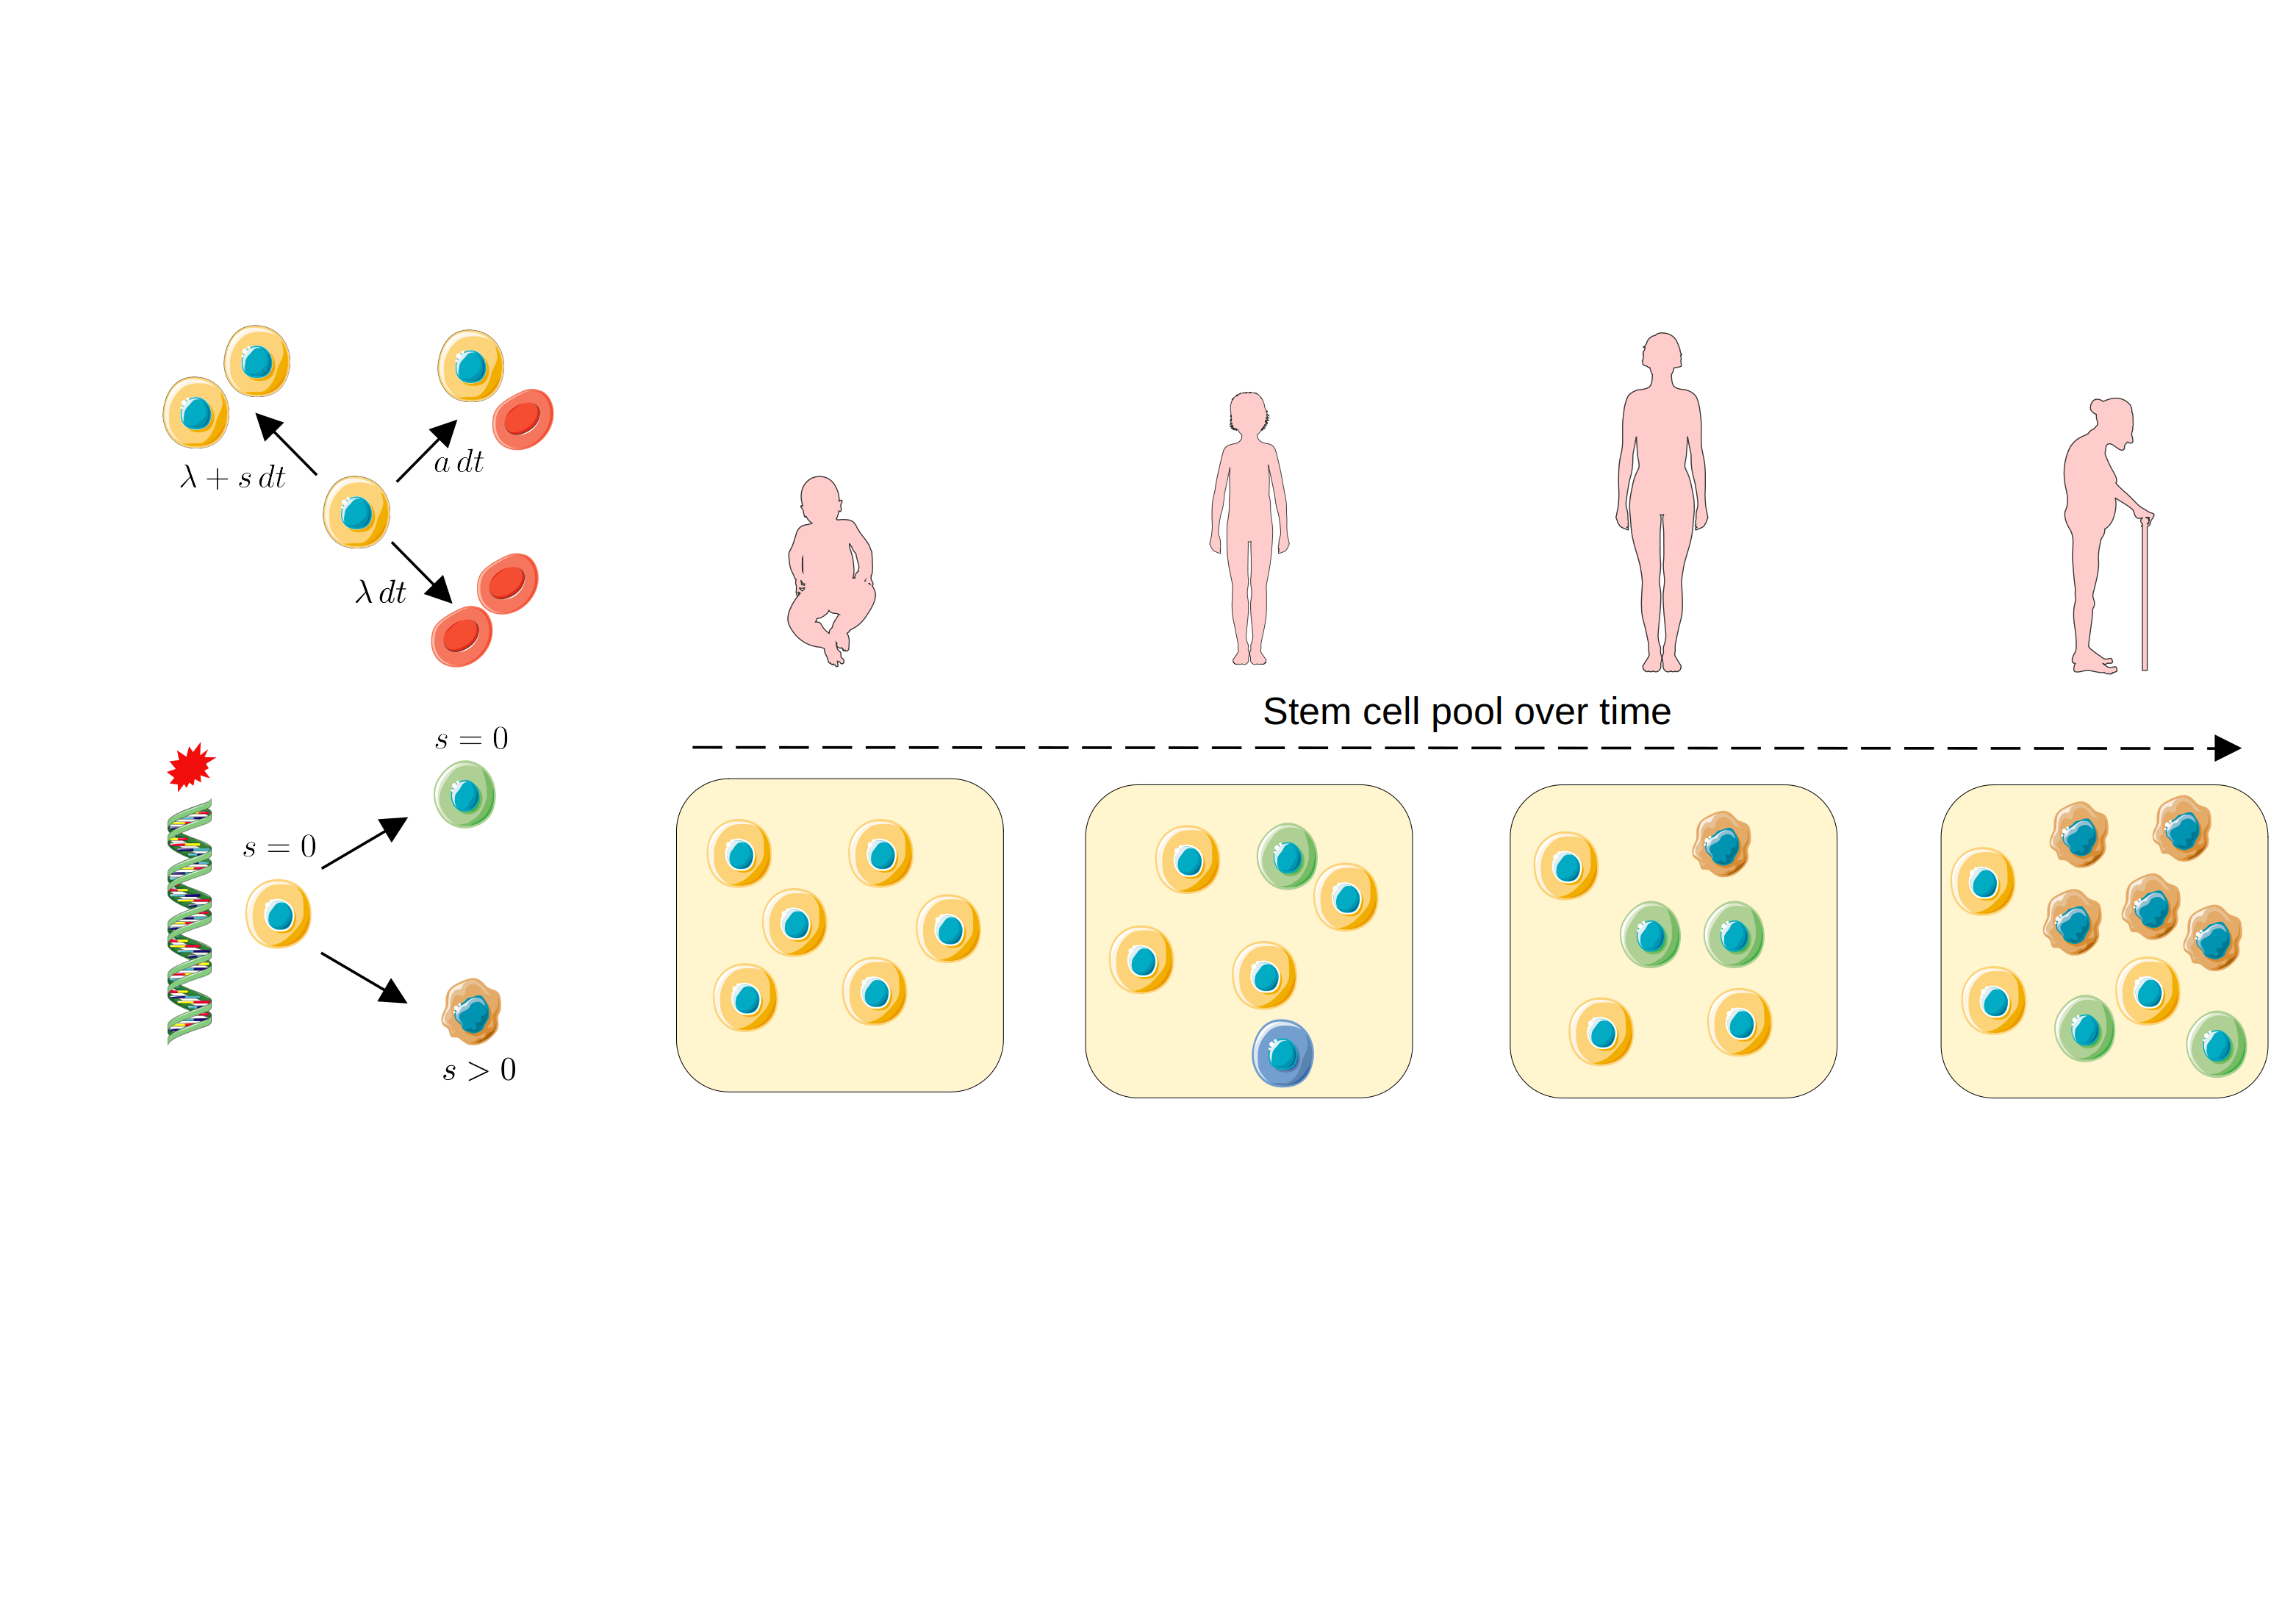

A clone follows a birth and death process with birth rate $\lambda + s$ and death rate $\lambda$, where $\lambda$ corresponds to the stem cell division rate in the absence of fitness inducing mutations ($\lambda = 1.3$). We call $s$ the proliferative advantage, or fitness, of the clone. 

### Import local library

In [3]:
import sys
sys.path.append('../stochastic_package')

import bd_model

### Simulate clone size trajectory

In [4]:
# Create a birth and death process
# Set seed
np.random.seed(1)

# Set patameters
init_time = np.random.uniform(0, 50)
s = 0.1

# Simulate birth and death processes
last_clone_size = 0
while last_clone_size == 0:
    clone_size_trajectory = bd_model.bd(t=init_time, 
                                        lamb=1.3 + s,
                                        from_zero=True)
    # Check clone size at last time point
    last_clone_size = clone_size_trajectory[1,-1]

clone_size_trajectory

array([[    0,     1,     2,     3,     4,     5,     6,     7,     8,
            9,    10,    11,    12,    13,    14,    15,    16,    17,
           18,    19,    20,    21,    22,    23,    24,    25,    26,
           27,    28,    29,    30,    31,    32,    33,    34,    35,
           36,    37,    38,    39,    40,    41,    42,    43,    44,
           45,    46,    47,    48,    49,    50,    51,    52,    53,
           54,    55,    56,    57,    58,    59,    60,    61,    62,
           63,    64,    65,    66,    67,    68,    69,    70,    71,
           72,    73,    74,    75,    76,    77,    78,    79,    80,
           81,    82,    83,    84,    85,    86,    87,    88,    89,
           90],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     1,     5,    10,     8,     7,     3,
           10,    12,    14,    10,    26,    37,    50,    4

In [5]:
# Plot clone size evolution
fig = px.line(x=clone_size_trajectory[0,:],
                   y=clone_size_trajectory[1,:])

fig.update_layout(title = 'Clone size evolution',
                  xaxis_title='Age',
                  yaxis_title='Clone size')
fig.show()

In [6]:
# Restrict to a set of ages
# We want to select ages spread 3 years appart

ages = [70, 73, 76, 79, 82]

# Extract allele propotion
clone_size_trajectory = clone_size_trajectory[:, ages]
clone_size_trajectory

array([[  70,   73,   76,   79,   82],
       [1447, 2108, 2727, 3606, 4846]])

## Simulate clonal VAF (variant allele frequency) trajectories

In our case, we do not have access to clonal cell counts but rather to an indirect measure. When sequencing fully differentiated blood, we can access the variant allele frequency of a mutation, that is the proportion of alleles carrying that mutation.
Assuming that each stem cell produces the same number of fully differentiated stem cells,

$$v_i(t) = \frac{n_i(t)}{2\left(N_w + n_i(t) \right)}$$

In [7]:
# Compute the vaf of the clone
N_w = np.random.randint(10_000, 50_000)

# Extract allele propotion
total_alleles = 2*(N_w + clone_size_trajectory[1,:])
vaf = clone_size_trajectory[1,:] / total_alleles

# Plot vaf evolution
fig = px.line(x=clone_size_trajectory[0,:], y=vaf)
fig.update_layout(title = 'Clonal vaf evolution',
                  xaxis_title='Age',
                  yaxis_title='AF')
fig.show()

# Simulate sequencing

When sequencing, a site of the genome is read DP times and the AF of a mutation is estimated as the proportion of alternate observations AO, AO/DP. 

We simulate this process through a binomial distribution: *probability distribution of observing k successes in n events given a probability of success p*.

In our case: **k=AO, n=DP, p=AO/DP**.

In [8]:
# Simulate binomial draw
DP = np.random.normal(loc=1_500, scale=100, size=len(ages)).astype(int)
AO = np.random.binomial(n=DP, p = vaf)

In [9]:
# Create dataframe
bd_df = pd.DataFrame({'age': ages,
                      'AF': AO/DP,
                      'DP': DP,
                      'AO': AO,
                      'clone_size': clone_size_trajectory[1,:]
                     })
bd_df

age        AF    DP   AO  clone_size
0   70  0.049842  1264   63        1447
1   73  0.060498  1405   85        2108
2   76  0.080070  1711  137        2727
3   79  0.098505  1472  145        3606
4   82  0.132911  1580  210        4846

In [10]:
# Plot vaf evolution
fig = go.Figure()
fig.add_trace(go.Scatter(x=clone_size_trajectory[0,:], y=vaf, name='True vaf'))
fig.add_trace(go.Scatter(x=bd_df.age, y=bd_df.AF, name='sequencing vaf'))

fig.update_layout(title = 'Clonal vaf evolution',
                  xaxis_title='Age',
                  yaxis_title='AF')
fig.show()

## Use function in bd_model package

In [11]:
# Call birth_death_sequencing function from bd_model package
trajectory = bd_model.birth_death_sequencing(s=0.1, N_w=50_000, seed=0)
trajectory

Mutation acquisition: 27.44, 
Fitness: 0.1, 
Stem cells: 50000


age        AF    DP  AO  clone_size
0   70  0.003232  1547   5         429
1   73  0.004881  1639   8         490
2   76  0.002597  1540   4         604
3   79  0.010453  1435  15         813
4   82  0.014571  1304  19         972

# Fitting data

We are going to fit a birth and death model to a time series data, to evaluate the probability of it being produced by a birth and death model.

## Parameters

This model uses fitness and initital time of mutation as parameters to fit, and assumes a fixed number of stem cells.

## Computing the negalite log-likelihood assuming a fixed number of stem cells

In [12]:
def bd_conditional_N_nll(params, trajectory, N_w=50_000,
                         return_params=False):
    """Compute negative log-likelihood of observing a time-series
    data conditional on the previous time point, assuming the data was produced
    by a birth and death process and conditional on a fixed number of stem
    cells N_w.

    Parameters
    -----------
    params: tuple (float, float). Tuple of floats determining the fitness
            (s_fit) and time of mutation acquisition (t_fit) used compute
            the nll.
    trajectory: Pandas DataFrame. Time-series dataset including columns:
                'AO, 'DP' and 'age'.
    N_w: int. Fixed number of wild type stem cells.
    return_params: Bool. Returns params. This is used during asynchronous
                   multiprocessing fitting, where parameters are not used
                   in order.
    returns
    -----------
    nll: float. negative log-likelihood of observing a given data.
    """
    # Extract parameters
    s_fit = params[0]  # fitness
    t_fit = params[1]  # initial time of mutation
    
    # Exatract inferred clone_sizes from AO/DP ratio
    mean_size, size_range = observations_to_clone_size(AO=trajectory.AO,
                                                       DP=trajectory.DP,
                                                       N_w=N_w)

    # Set inferred size as the mean of all possible ranges of observations
    trajectory['inferred_size'] = mean_size

    # Compute time_steps
    trajectory['delta_t'] = np.insert(np.diff(trajectory.age),
                                      0, trajectory.iloc[0].age - t_fit)
    # Initialise negative log-likelihood computation
    nll = 0
    for i, time_point in trajectory.iterrows():
        # Extract initial clone_size and time difference between observations
        if i == 0:
            init_size = 1
        else:
            init_size = trajectory.iloc[i-1].inferred_size

        # Compute AO/DP observation probability at next time point
        prob = AO_prob_value(AO=time_point.AO,
                             DP=time_point.DP,
                             init_size=init_size,
                             s=s_fit,
                             delta_t=time_point.delta_t,
                             N_w=N_w)

        # Avoid divide by zero encountered in log warning
        if prob < 1.0e-100:
            prob = 1.0e-100

        # Compute negative log likelihood
        nll -= np.log(prob)

    if return_params is True:
        return nll, params
    else:
        return nll

### Step 1: extract parameters 

In [13]:
# for explanation purposes fix 
params = [0.1, 10]

# also fix N_w
N_w = 50_000

In [14]:
# Extract parameters
s_fit = params[0]  # fitness
t_fit = params[1]  # initial time of mutation

### Geting an estimate of the clone size
We first need to obtain an estimate of the clon size at each time point

In [15]:
def observations_to_clone_size(AO, DP, N_w):
    """Find all clone sizes leading to the same observed AO/DP ratio.
    We assume that the binomial draw selects exactly
    AO = DPx/(2N+2x), where x is the true clone size.
    We then use the inverse function of
    f(x) = DPx/(2N+2x), f-1(x) = 2Nx/(DP-2x)
    to estimate upper and lower bounds of all possible clone sizes.

    Parameters:
    -----------
    AO: int. Alternate allele depth.
    DP: int. Total deepth at position.
    N_w: int. Wild-type stem cells count.

    Returns:
    -----------
    mean_size, size_range. Tuple. Estimated average clone size and range
                           of inferred clone sizes.
    """

    # Compute extreme approximate sizes
    min_size = 2*N_w*AO/(DP-2*AO)
    max_size = 2*N_w*(AO+1)/(DP-2*(AO+1))

    # Deal with the case AO = 0, min_size = 0
    min_size = np.where(min_size == 0, 1, min_size)

    # Retrieve clone sizes in the extremes.
    size_range = np.array([np.ceil(min_size), np.floor(max_size)]).astype(int)

    # Compute average size
    mean_size = size_range.mean(axis=0).astype(int)

    return mean_size, size_range

mean_size, size_range = observations_to_clone_size(trajectory.AO, trajectory.DP, N_w=N_w)
# Set inferred size as the mean of all possible ranges of observations
trajectory['inferred_size'] = mean_size
trajectory

age        AF    DP  AO  clone_size  inferred_size
0   70  0.003232  1547   5         429            358
1   73  0.004881  1639   8         490            524
2   76  0.002597  1540   4         604            294
3   79  0.010453  1435  15         813           1104
4   82  0.014571  1304  19         972           1541

### Computing the time-difference between time-series observations

In [16]:
# Compute time_steps
trajectory['delta_t'] = np.insert(np.diff(trajectory.age),
                                  0, trajectory.iloc[0].age - t_fit)
trajectory

age        AF    DP  AO  clone_size  inferred_size  delta_t
0   70  0.003232  1547   5         429            358       60
1   73  0.004881  1639   8         490            524        3
2   76  0.002597  1540   4         604            294        3
3   79  0.010453  1435  15         813           1104        3
4   82  0.014571  1304  19         972           1541        3

## Compute AO|DP probability from initial clone size 

The exact probability distribution of a birth and death process with fitness $s>0$ and initial clone size $x_s(t_0) = a$ at time zero is given by:
$$
\mathbb{P}\left\{ x_s(t) = m \vert x_s(t_0)=a \right\}=\begin{cases}
\sum_{j=0}^{\min\left(a,m\right)}{a \choose j}{a+m-j-1 \choose a-1}\alpha^{a-j}\beta^{m-j}\left(1-\alpha-\beta\right)^{j}, & m>0,\\
\alpha^{a}, & m=0.
\end{cases}
$$

where 
$$
\alpha=\frac{\lambda\left(e^{s\Delta t}-1\right)}{\left(\lambda + s\right)e^{ s\Delta t}-\lambda},\quad\beta=\frac{\left(\lambda + s\right)\left(e^{ s\Delta t}-1\right)}{\left(\lambda + s\right)e^{ s\Delta t}-\lambda}
$$ and $\Delta t = t-t_0$.

The mean and variance of this distribution is
$$
\mu_{x_s}\left(t\right)=ae^{s\Delta t} \quad \text{and}\quad\sigma_{x_s}^{2}\left(t\right)=\frac{a\left(2\lambda + s\right)}{s}e^{s\Delta t}\left(e^{s \Delta t}-1\right).
$$

The resulting distribubtion of clone sizes at time t can be approximated by a negative binomial distribution.

Further, the negative binomial distribution pmf
$$f(k) = {k+n-1\choose n-1} p^n (1-p)^k$$

can be described in terms of its mean and variance:
$$p = \frac{\mu}{\sigma^2}, \quad \text{and} \quad n=\frac{\mu ^2}{\sigma^2-\mu}.$$ 

In [17]:
trajectory

age        AF    DP  AO  clone_size  inferred_size  delta_t
0   70  0.003232  1547   5         429            358       60
1   73  0.004881  1639   8         490            524        3
2   76  0.002597  1540   4         604            294        3
3   79  0.010453  1435  15         813           1104        3
4   82  0.014571  1304  19         972           1541        3

In [18]:
from scipy.stats import nbinom

size_sample = 1_000

init_size = trajectory.iloc[0].inferred_size
delta_t = trajectory.iloc[1].delta_t
AO = trajectory.iloc[1].AO
DP = trajectory.iloc[1].DP

# extract mean and variance of BD process
mean, variance = distributions.BD_stats(init_size=init_size,
                                        s=s_fit,
                                        delta_t=delta_t)

# negative binomial probability and number of successes
p = mean / variance
n = np.power(mean, 2) / (variance-mean)

# Extract a 1_000 clone_sizes according to their probability
random_size_states = nbinom.rvs(n, p,
                                size=size_sample,
                                random_state=123)

unique_random_size_states = np.unique(random_size_states)


# Compute the associated probability for each clone size
# of being observed in a BD process
clone_size_bd_prob = distributions.nb_approx(
                size=unique_random_size_states,
                init_size=init_size,
                s=s_fit,
                delta_t=delta_t)

clone_size_bd_prob = clone_size_bd_prob / sum(clone_size_bd_prob)

px.line(x=unique_random_size_states, y=clone_size_bd_prob)

In [19]:
# Compute the allele proportion for each resulting clone_size
total_alleles = 2*(N_w + unique_random_size_states)
allele_proportion_range = unique_random_size_states / total_alleles

# Compute the probability of observing AO given DP and the allele proportion
# after sequencing using binomial distribution
sequencing_prob = binom.pmf(AO, DP, p=allele_proportion_range)

# marginalise the sequencing probability by clone size
sequencing_prob = sum(clone_size_bd_prob*sequencing_prob)
sequencing_prob

0.13177694360883113

## Altogether

In [20]:
nll = filtering.bd_conditional_N_nll(params=params, trajectory=trajectory)
nll

22.867471156176798

# Fitting optimal parameters

In [21]:
fitness_bounds = (0,0.5)

def bd_N_fit(params=None, trajectory=None, N_w=50_000,
             method='Powell'):
    """Compute the minimium negative log-likelihood of observing a time-series
    data, assuming the data was produced by a birth and death process and a
    fixed number of stem cells.

    Parameters
    -----------
    params: tuple (float, float). Tuple of floats determining the fitness
            and time of mutation initiaion used to iniate the fitting
            proccess. By default this is set to their bounds' mean.
    trajectory: Pandas DataFrame. Time-series dataset including columns:
                'AO, 'DP' and 'age'.
    N_w: int. Number of wild type stem cells.
    method: str. Solver algorithm used during minimization process.
            A full list of allowed strings can be found in the documentation
            of scipy.optimize.minimize:
            https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

    returns
    -----------
    model: trajectory_model class. Optimized fit of a birth and
           death distribution to describe the time-series data.
     """

    # parameter bounds
    #set t0_bounds as any age between birth and first observation
    t0_bounds = (0, trajectory.iloc[0].age-1)
    if params is None:
        s_init = np.mean(fitness_bounds)
        t0_init = np.mean(t0_bounds)

    else:
        s_init, t0_init = params

    bounds = (fitness_bounds, t0_bounds)

    # initial parameters
    x0 = np.array([s_init, t0_init])

    model = minimize(filtering.bd_conditional_N_nll, x0=x0, bounds=bounds,
                     args=(trajectory, N_w), method=method)


    return model

In [22]:
model = bd_N_fit(trajectory=trajectory, method='Powell', N_w=50_000)
model

   direc: array([[1., 0.],
       [0., 1.]])
     fun: 22.000417491447227
 message: 'Optimization terminated successfully.'
    nfev: 88
     nit: 2
  status: 0
 success: True
       x: array([ 0.15341758, 34.04617641])

# Do not condition on the inital time of mutation!

In [23]:
def bd_conditional_N_nll(params, trajectory, N_w=50_000,
                         return_params=False):
    """Compute negative log-likelihood of observing a time-series
    data conditional on the previous time point, assuming the data was produced
    by a birth and death process and conditional on a fixed number of stem
    cells N_w.

    Parameters
    -----------
    params: tuple (float, float). Tuple of floats determining the fitness
            (s_fit) and time of mutation acquisition (t_fit) used compute
            the nll.
    trajectory: Pandas DataFrame. Time-series dataset including columns:
                'AO, 'DP' and 'age'.
    N_w: int. Fixed number of wild type stem cells.
    return_params: Bool. Returns params. This is used during asynchronous
                   multiprocessing fitting, where parameters are not used
                   in order.
    returns
    -----------
    nll: float. negative log-likelihood of observing a given data.
    """
    # Extract parameters
    s_fit = params[0]  # fitness
    
    # Exatract inferred clone_sizes from AO/DP ratio
    mean_size, size_range = filtering.observations_to_clone_size(AO=trajectory.AO,
                                                       DP=trajectory.DP,
                                                       N_w=N_w)

    # Set inferred size as the mean of all possible ranges of observations
    trajectory['inferred_size'] = mean_size

    # Compute time_steps
    trajectory['delta_t'] = np.insert(np.diff(trajectory.age),
                                      0, 0)

    # Initialise negative log-likelihood computation
    nll = 0
    for i, time_point in trajectory.iterrows():
        if i == 0:
            continue
        # Extract initial clone_size and time difference between observations
        init_size = trajectory.iloc[i-1].inferred_size

        # Compute AO/DP observation probability at next time point
        prob = filtering.AO_prob_value(AO=time_point.AO,
                                       DP=time_point.DP,
                             init_size=init_size,
                             s=s_fit,
                             delta_t=time_point.delta_t,
                             N_w=N_w)

        # Avoid divide by zero encountered in log warning
        if prob < 1.0e-100:
            prob = 1.0e-100

        # Compute negative log likelihood
        nll -= np.log(prob)

    if return_params is True:
        return nll, params
    else:
        return nll
    
from scipy.optimize import minimize
fitness_bounds = (0, 0.5)


def bd_N_fit_2(params=None, trajectory=None, N_w=50_000,
             method='Powell'):
    """Compute the minimium negative log-likelihood of observing a time-series
    data, assuming the data was produced by a birth and death process and a
    fixed number of stem cells.

    Parameters
    -----------
    params: tuple (float, float). Tuple of floats determining the fitness
            and time of mutation initiaion used to iniate the fitting
            proccess. By default this is set to their bounds' mean.
    trajectory: Pandas DataFrame. Time-series dataset including columns:
                'AO, 'DP' and 'age'.
    N_w: int. Number of wild type stem cells.
    method: str. Solver algorithm used during minimization process.
            A full list of allowed strings can be found in the documentation
            of scipy.optimize.minimize:
            https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

    returns
    -----------
    model: trajectory_model class. Optimized fit of a birth and
           death distribution to describe the time-series data.
     """

    # parameter bounds
    if params is None:
        s_init = np.mean(fitness_bounds)

    else:
        s_init = params

    bounds = [fitness_bounds]

    # initial parameters
    x0 = np.array([s_init])

    model = minimize(bd_conditional_N_nll, x0=x0, bounds=bounds,
                     args=(trajectory, N_w), method=method)


    return model

In [24]:
bd_N_fit_2(trajectory=trajectory)

   direc: array([[-1.40849297e-14]])
     fun: 15.642197178189708
 message: 'Optimization terminated successfully.'
    nfev: 194
     nit: 3
  status: 0
 success: True
       x: array([0.12708963])